# ０～９までの数字の画像からどの数字なのかを推論する畳み込みニューラルネットワーク（CNN）モデルの構築

#### データセットの準備

In [35]:
!pip install datasets
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 68.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=44422b1f05eb6370c684fc6e9985dbc545fa8d66b7807794ffcb23c22fde4405
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize-matplotlib


In [3]:
from datasets import load_dataset
ds = load_dataset("ylecun/mnist")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [36]:
import torch
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

#### データセットの確認

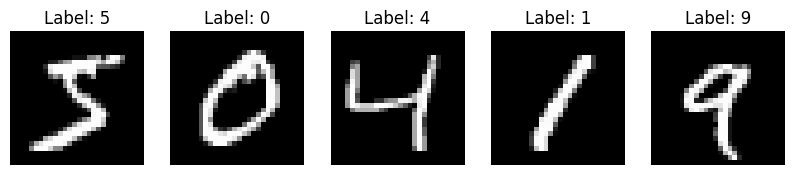

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    image = ds['train'][i]['image']
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {ds['train'][i]['label']}")
    ax.axis('off')
plt.show()

In [6]:
ds['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 5}

In [7]:
print(f"画像サイズ {image.size}")

画像サイズ (28, 28)


In [8]:
# 型の変換
ds.set_format(type='torch', columns=['image', 'label'])

#### 畳み込みニューラルネットワークのモデルを定義

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPUを使用します")
else:
    device = torch.device("cpu")
    print("CPUを使用します")
print(device)

GPUを使用します
cuda


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # x = x.view(-1, 64)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


##### モデルの動作確認

In [11]:
# 1つ目のデータを取得
train_loader = torch.utils.data.DataLoader(ds['train'])
data_iter = iter(train_loader)
batch = next(data_iter)
images, labels = batch['image'], batch['label']
print(images.size())
print(labels)

torch.Size([1, 1, 28, 28])
tensor([5])


In [12]:
# 1つ目のデータをモデルに入力
pred = model(images.squeeze(2).float().to(device))
print(f"output shape: {pred.shape}")
print(pred.min(), pred.max())
print(pred)

output shape: torch.Size([1, 10])
tensor(0.0008, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5981, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([[0.0043, 0.0039, 0.5981, 0.0076, 0.0062, 0.0008, 0.0448, 0.2583, 0.0201,
         0.0558]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


#### 損失関数とオプティマイザーを設定

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

#### モデルを訓練

In [14]:
targets = ds['train']['label'].numpy()
class_counts = np.bincount(targets)
class_weights = 1 / class_counts
sample_weights = class_weights[targets]

sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [47]:
# データローダーの作成
train_loader = torch.utils.data.DataLoader(ds['train'], batch_size=64, sampler=sampler)

# モデルの訓練
model.train()
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data['image'], data['label']
        inputs = inputs.squeeze(2).float().to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f"エポック {epoch+1}\nイテレーション {i+1}\n損失: {running_loss / (i+1)}\n精度: {100 * correct / total}")
        print("---------------------------------------------")

print("完了")

ストリーミング出力は最後の 5000 行に切り捨てられました。
イテレーション 877
損失: 1.4762655900304917
精度: 98.4713511972634
---------------------------------------------
エポック 4
イテレーション 878
損失: 1.4762662583983297
精度: 98.47131264236901
---------------------------------------------
エポック 4
イテレーション 879
損失: 1.476249062160583
精度: 98.47305176336747
---------------------------------------------
エポック 4
イテレーション 880
損失: 1.4762496793811972
精度: 98.47301136363636
---------------------------------------------
エポック 4
イテレーション 881
損失: 1.4762325409998553
精度: 98.47474460839955
---------------------------------------------
エポック 4
イテレーション 882
損失: 1.4762331131093898
精度: 98.47470238095238
---------------------------------------------
エポック 4
イテレーション 883
損失: 1.4762337276646667
精度: 98.47466024915062
---------------------------------------------
エポック 4
イテレーション 884
損失: 1.4762166665689977
精度: 98.47638574660634
---------------------------------------------
エポック 4
イテレーション 885
損失: 1.476217298184411
精度: 98.4763418079096
-----------------------------------

In [16]:
print(predicted)
print(labels)

tensor([3, 1, 1, 4, 7, 5, 6, 3, 4, 6, 9, 2, 7, 2, 5, 9, 8, 5, 4, 7, 0, 8, 0, 5,
        6, 7, 9, 8, 5, 3, 7, 9], device='cuda:0')
tensor([3, 1, 1, 4, 7, 5, 6, 2, 4, 6, 9, 2, 7, 2, 5, 8, 8, 5, 4, 7, 0, 8, 0, 5,
        6, 7, 9, 8, 5, 3, 7, 9], device='cuda:0')


#### 評価

In [39]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# モデルを評価モードに設定
model.eval()
correct = 0

# データローダーを作成 (シャッフルなし)
test_loader = torch.utils.data.DataLoader(ds['train'], batch_size=64, shuffle=False)

# 予測とラベルを格納するリスト
predicts_list = []
labels_list = []
probs_list = []  # ROC曲線用の確率を格納

# 勾配計算を無効化
with torch.no_grad():
    for data in test_loader:
        # 画像とラベルを取得
        images, labels = data['image'], data['label']
        # 画像を適切な形状に変換し、デバイスに転送
        images = images.squeeze(2).float().to(device)
        labels = labels.to(device)

        # モデルに画像を入力して出力を取得
        outpts = model(images)
        # クラス1の確率を取得 (二値分類の場合)
        probs = outpts[:, 1]
        # 確率をリストに追加
        probs_list.extend(probs.cpu().numpy())

        # 予測結果を取得
        _, predicted = torch.max(outpts.data, 1)
        # 正答数を更新
        correct += (predicted == labels).sum().item()
        # 予測結果をNumPy配列に変換してリストに追加
        predicts_list.extend(predicted.cpu().numpy())
        # ラベルをNumPy配列に変換してリストに追加
        labels_list.extend(labels.cpu().numpy())

        # バッチごとの精度を出力 (監視用)
        print(f"出力の形状: {outpts.shape}")
        print(f"予測: {predicted}\n実際: {labels}")
        print(f"バッチ精度: {100 * (predicted == labels).sum().item() / len(labels):.2f}%")
        print("-----------------------------------------------------------------")

ストリーミング出力は最後の 5000 行に切り捨てられました。
        4, 5, 6, 6, 0, 7, 9, 8, 0, 3, 9, 1, 2, 2, 6, 1, 6, 9, 5, 2, 5, 4, 9, 0,
        9, 9, 8, 9, 7, 3, 7, 7, 5, 7, 4, 9, 9, 1, 0, 4], device='cuda:0')
実際: tensor([3, 2, 2, 3, 3, 6, 9, 7, 4, 8, 6, 9, 8, 1, 2, 0, 7, 1, 1, 2, 9, 3, 1, 4,
        4, 5, 6, 6, 0, 7, 9, 8, 0, 3, 9, 1, 2, 2, 6, 1, 6, 9, 5, 2, 5, 4, 9, 0,
        9, 9, 8, 9, 7, 3, 7, 7, 5, 7, 4, 9, 9, 1, 0, 4], device='cuda:0')
バッチ精度: 100.00%
-----------------------------------------------------------------
出力の形状: torch.Size([64, 10])
予測: tensor([3, 7, 4, 7, 5, 2, 7, 5, 2, 8, 6, 6, 3, 0, 5, 4, 3, 0, 4, 5, 3, 8, 8, 1,
        1, 0, 9, 3, 7, 0, 4, 4, 7, 7, 2, 4, 7, 9, 7, 2, 2, 9, 6, 1, 9, 2, 8, 5,
        3, 7, 8, 1, 1, 7, 9, 1, 7, 6, 1, 7, 7, 3, 5, 3], device='cuda:0')
実際: tensor([3, 2, 4, 7, 5, 2, 7, 5, 2, 8, 6, 6, 3, 0, 6, 4, 3, 0, 4, 3, 3, 8, 8, 1,
        1, 0, 9, 3, 7, 0, 4, 4, 7, 7, 2, 4, 7, 9, 7, 2, 2, 9, 6, 1, 9, 2, 8, 5,
        3, 7, 8, 1, 1, 7, 9, 1, 7, 6, 2, 7, 7, 3, 5, 3], device='

In [40]:
print(f"predicts: {predicts_list[:10]}")
print(f"labels: {labels_list[:10]}")

predicts: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]
labels: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


##### ヒートマップでビジュアライズ


全体の精度: 97.7400%
全体の適合率: 97.7777%
全体の再現率: 97.7400%
全体のF1スコア: 97.7325%

分類レポート:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5923
           1       0.98      0.99      0.98      6742
           2       1.00      0.91      0.95      5958
           3       0.96      0.97      0.97      6131
           4       0.99      0.98      0.98      5842
           5       0.96      0.99      0.98      5421
           6       0.99      0.98      0.99      5918
           7       0.96      0.99      0.98      6265
           8       0.97      0.98      0.97      5851
           9       0.97      0.98      0.98      5949

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000



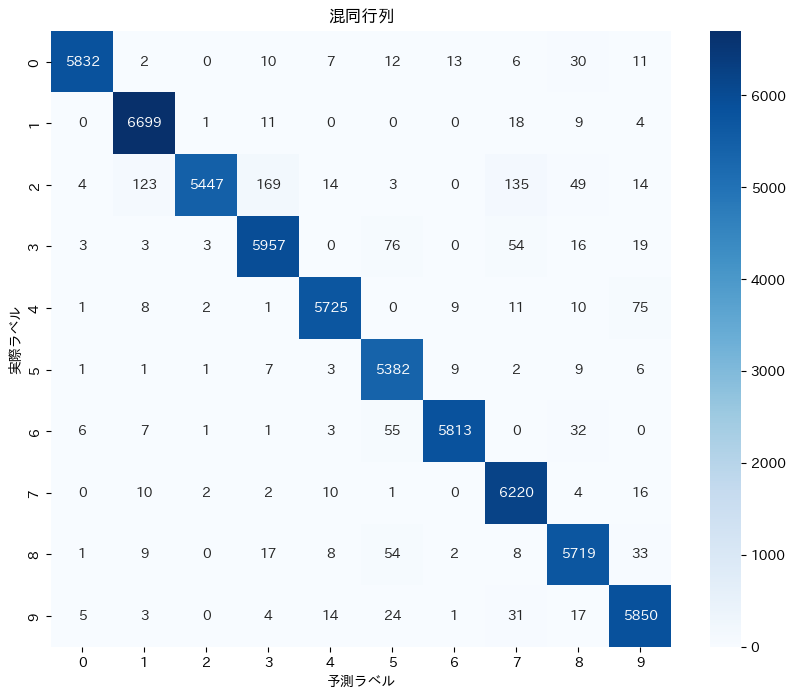

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 全体的な指標を計算して出力
accuracy = accuracy_score(labels_list, predicts_list)
precision = precision_score(labels_list, predicts_list, average='weighted')
recall = recall_score(labels_list, predicts_list, average='weighted')
f1 = f1_score(labels_list, predicts_list, average='weighted')

print(f"\n全体の精度: {accuracy * 100:.4f}%")
print(f"全体の適合率: {precision * 100:.4f}%")
print(f"全体の再現率: {recall * 100:.4f}%")
print(f"全体のF1スコア: {f1 * 100:.4f}%")

# 分類レポートを出力
print("\n分類レポート:")
print(classification_report(labels_list, predicts_list))

# 混同行列をプロット
cm = confusion_matrix(labels_list, predicts_list)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("混同行列")
plt.xlabel("予測ラベル")
plt.ylabel("実際ラベル")
plt.show()

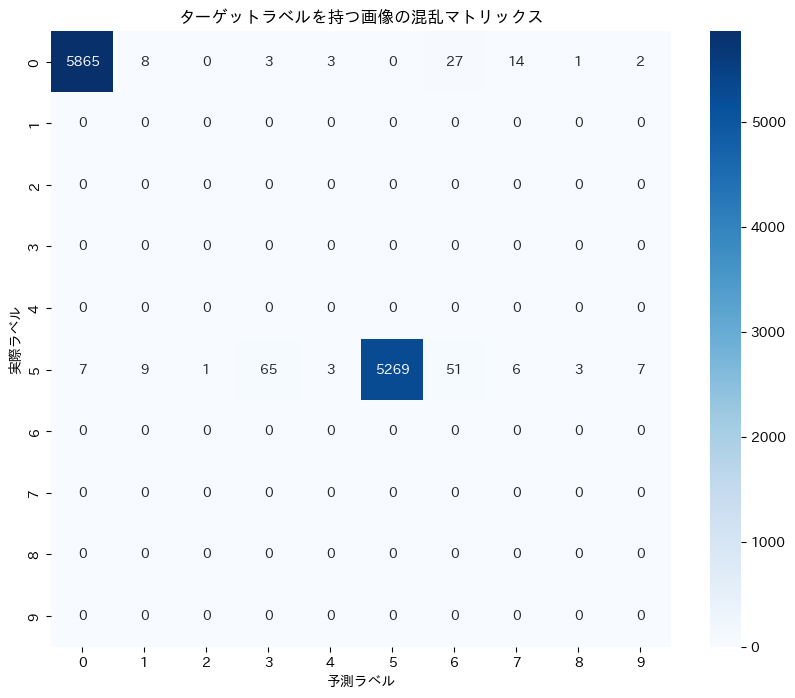

In [48]:
# 特定のラベルがついた画像のみをモデルに入力して、予測結果をヒートマップでプロット
model.eval()
target = [0, 5]
target_images = []
target_labels = []
target_predictions = []

with torch.no_grad():
    for i in range(len(ds['train'])):
        if ds['train'][i]['label'] in target:
            image = ds['train'][i]['image'].unsqueeze(0).float().to(device)
            label = ds['train'][i]['label']
            output = model(image)
            _, predicted = torch.max(output, 1)

            target_images.append(image)
            target_labels.append(label.item())
            target_predictions.append(predicted.cpu().item())

target_labels_tensor = torch.tensor(target_labels)
target_predictions_tensor = torch.tensor(target_predictions)

cm = confusion_matrix(target_labels_tensor, target_predictions_tensor)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("ターゲットラベルを持つ画像の混乱マトリックス")
plt.xlabel("予測ラベル")
plt.ylabel("実際ラベル")
plt.show()